In [24]:
import os
import shutil
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from PIL import Image
from hashlib import md5

# === CONFIG ===
SOURCE_DIR = "train_images"
DEST_DIR = "dataset"
META_CSV = "meta_train.csv"
IMG_EXT = (".jpg", ".jpeg", ".png")
LOG_PREFIX = "[CLEAN]"

# === Load metadata ===
print(f"{LOG_PREFIX} Loading metadata...")
df = pd.read_csv(META_CSV)
df['image_id'] = df['image_id'].astype(str)

# === Check for duplicate metadata entries ===
dupe_count = df['image_id'].duplicated().sum()
print(f"{LOG_PREFIX} Duplicate image_id entries in CSV: {dupe_count}")

# === Verify that label folders exist ===
label_folders = set(os.listdir(SOURCE_DIR))
csv_labels = set(df['label'].unique())
invalid_labels = csv_labels - label_folders
if invalid_labels:
    print(f"{LOG_PREFIX} ❌ Labels in CSV not found in image folders: {invalid_labels}")
else:
    print(f"{LOG_PREFIX} ✅ All CSV labels match image folders.")

# === Check that images listed in metadata exist ===
print(f"{LOG_PREFIX} Checking file existence...")
valid_images = []
valid_labels = []
missing = 0

for _, row in df.iterrows():
    img_name = row['image_id']
    label = row['label']
    path = os.path.join(SOURCE_DIR, label, img_name)
    if os.path.isfile(path):
        valid_images.append(path)
        valid_labels.append(label)
    else:
        missing += 1

print(f"{LOG_PREFIX} ✅ Valid image files found: {len(valid_images)}")
if missing:
    print(f"{LOG_PREFIX} ❌ Missing images: {missing}")

# === Check for corrupted/unreadable images ===
print(f"{LOG_PREFIX} Checking for corrupted images...")
corrupted_paths = []

for path in valid_images:
    try:
        with Image.open(path) as img:
            img.verify()
    except Exception:
        corrupted_paths.append(path)

print(f"{LOG_PREFIX} ✅ Healthy images: {len(valid_images) - len(corrupted_paths)}")
print(f"{LOG_PREFIX} ❌ Corrupted images: {len(corrupted_paths)}")

# === Remove corrupted images from list ===
valid_image_set = set(valid_images) - set(corrupted_paths)
valid_images = [p for p in valid_images if p in valid_image_set]
valid_labels = [l for p, l in zip(valid_images, valid_labels) if p in valid_image_set]

# === Check for duplicate image content ===
print(f"{LOG_PREFIX} Checking for duplicate image content...")
hashes = {}
duplicate_content = []

for path in valid_images:
    try:
        with Image.open(path) as img:
            img_hash = md5(img.tobytes()).hexdigest()
            if img_hash in hashes:
                duplicate_content.append((path, hashes[img_hash]))
            else:
                hashes[img_hash] = path
    except:
        continue  # Already handled in corruption check

print(f"{LOG_PREFIX} ✅ Unique image content: {len(valid_images) - len(duplicate_content)}")
print(f"{LOG_PREFIX} ⚠️ Duplicate image content found: {len(duplicate_content)}")

# === Final train/val split ===
print(f"{LOG_PREFIX} Splitting cleaned data into train/val (80/20)...")
train_paths, val_paths, train_labels, val_labels = train_test_split(
    valid_images, valid_labels, test_size=0.2, stratify=valid_labels, random_state=42
)

# === Function to copy files ===
def copy_files(paths, labels, subset):
    for path, label in zip(paths, labels):
        dest = os.path.join(DEST_DIR, subset, label)
        os.makedirs(dest, exist_ok=True)
        shutil.copy(path, dest)

# === Clear destination ===
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)

copy_files(train_paths, train_labels, "train")
copy_files(val_paths, val_labels, "val")

print(f"{LOG_PREFIX} ✅ Finished: dataset/train/ and dataset/val/ created with clean data.")


[CLEAN] Loading metadata...
[CLEAN] Duplicate image_id entries in CSV: 0
[CLEAN] ✅ All CSV labels match image folders.
[CLEAN] Checking file existence...
[CLEAN] ✅ Valid image files found: 10407
[CLEAN] Checking for corrupted images...
[CLEAN] ✅ Healthy images: 10407
[CLEAN] ❌ Corrupted images: 0
[CLEAN] Checking for duplicate image content...
[CLEAN] ✅ Unique image content: 10333
[CLEAN] ⚠️ Duplicate image content found: 74
[CLEAN] Splitting cleaned data into train/val (80/20)...
[CLEAN] ✅ Finished: dataset/train/ and dataset/val/ created with clean data.


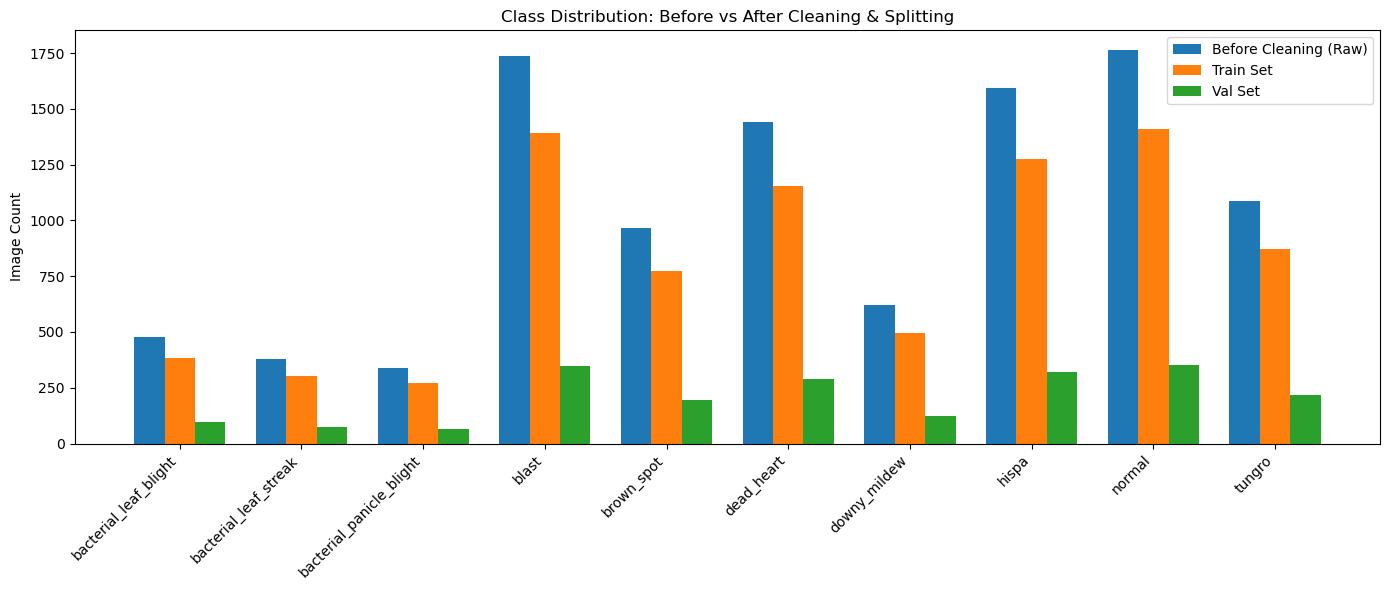

In [26]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# === CONFIG ===
RAW_DIR = "train_images"
CLEAN_DIR = "dataset"
SUBSETS = ["train", "val"]
IMG_EXT = (".jpg", ".jpeg", ".png")

def count_images_in_folder(folder_path):
    class_counts = defaultdict(int)
    for class_name in sorted(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue
        count = sum(fname.lower().endswith(IMG_EXT) for fname in os.listdir(class_path))
        class_counts[class_name] = count
    return class_counts

def count_all_subsets(clean_dir):
    all_counts = defaultdict(lambda: {"train": 0, "val": 0})
    for subset in SUBSETS:
        subset_dir = os.path.join(clean_dir, subset)
        counts = count_images_in_folder(subset_dir)
        for cls, cnt in counts.items():
            all_counts[cls][subset] = cnt
    return all_counts

# === Count before cleaning ===
raw_counts = count_images_in_folder(RAW_DIR)

# === Count after cleaning/split ===
split_counts = count_all_subsets(CLEAN_DIR)

# === Plot before/after comparison ===
labels = sorted(raw_counts.keys())
raw_values = [raw_counts[lbl] for lbl in labels]
train_values = [split_counts[lbl]["train"] for lbl in labels]
val_values = [split_counts[lbl]["val"] for lbl in labels]

x = range(len(labels))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar([i - width for i in x], raw_values, width=width, label="Before Cleaning (Raw)")
plt.bar(x, train_values, width=width, label="Train Set")
plt.bar([i + width for i in x], val_values, width=width, label="Val Set")

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Image Count")
plt.title("Class Distribution: Before vs After Cleaning & Splitting")
plt.legend()
plt.tight_layout()
plt.show()


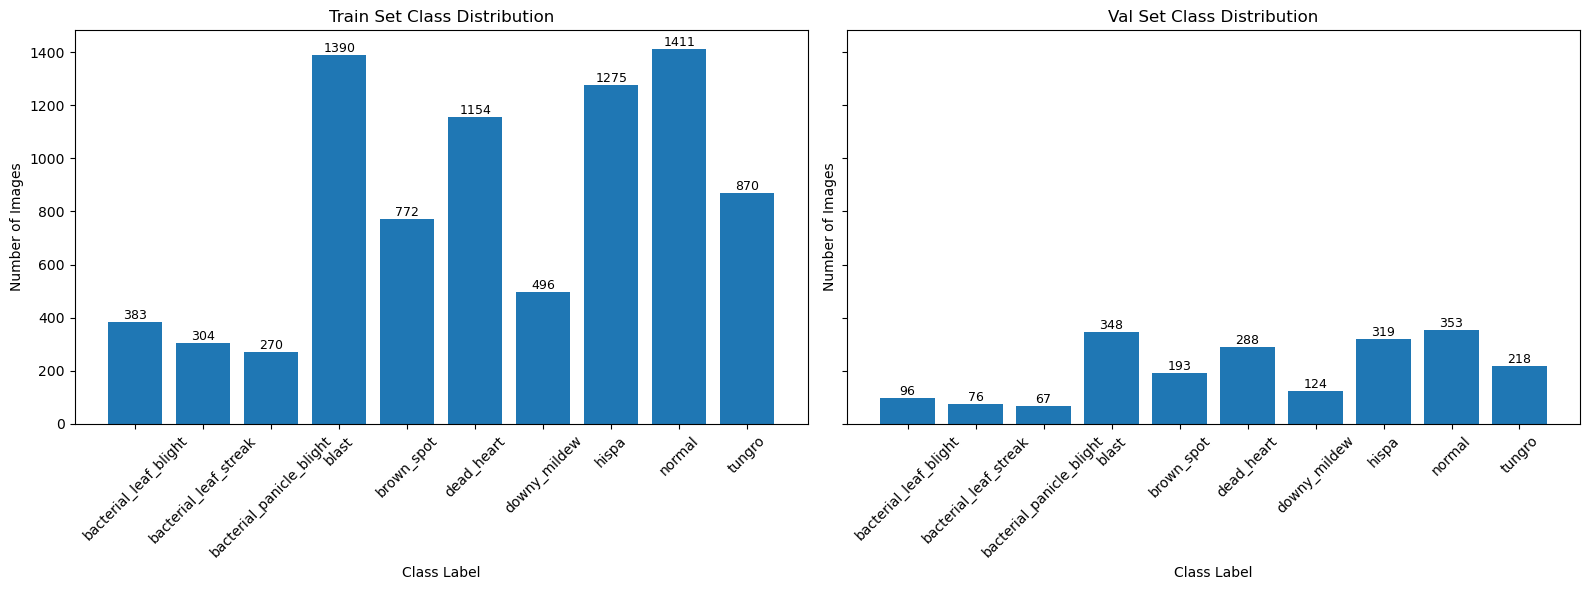

In [28]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# === CONFIG ===
DATASET_DIR = "dataset"
SUBSETS = ["train", "val"]
IMG_EXT = (".jpg", ".jpeg", ".png")

# === Count images per class in each subset ===
def count_images(subset_dir):
    class_counts = defaultdict(int)
    for class_name in sorted(os.listdir(subset_dir)):
        class_path = os.path.join(subset_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = sum(fname.lower().endswith(IMG_EXT) for fname in os.listdir(class_path))
        class_counts[class_name] = count
    return class_counts

# === Plot distributions ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for i, subset in enumerate(SUBSETS):
    subset_dir = os.path.join(DATASET_DIR, subset)
    counts = count_images(subset_dir)
    labels = list(counts.keys())
    values = [counts[label] for label in labels]

    axes[i].bar(labels, values)
    axes[i].set_title(f"{subset.capitalize()} Set Class Distribution")
    axes[i].set_xlabel("Class Label")
    axes[i].set_ylabel("Number of Images")
    axes[i].tick_params(axis='x', rotation=45)
    
    # Optional: add count labels
    for j, val in enumerate(values):
        axes[i].text(j, val, str(val), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


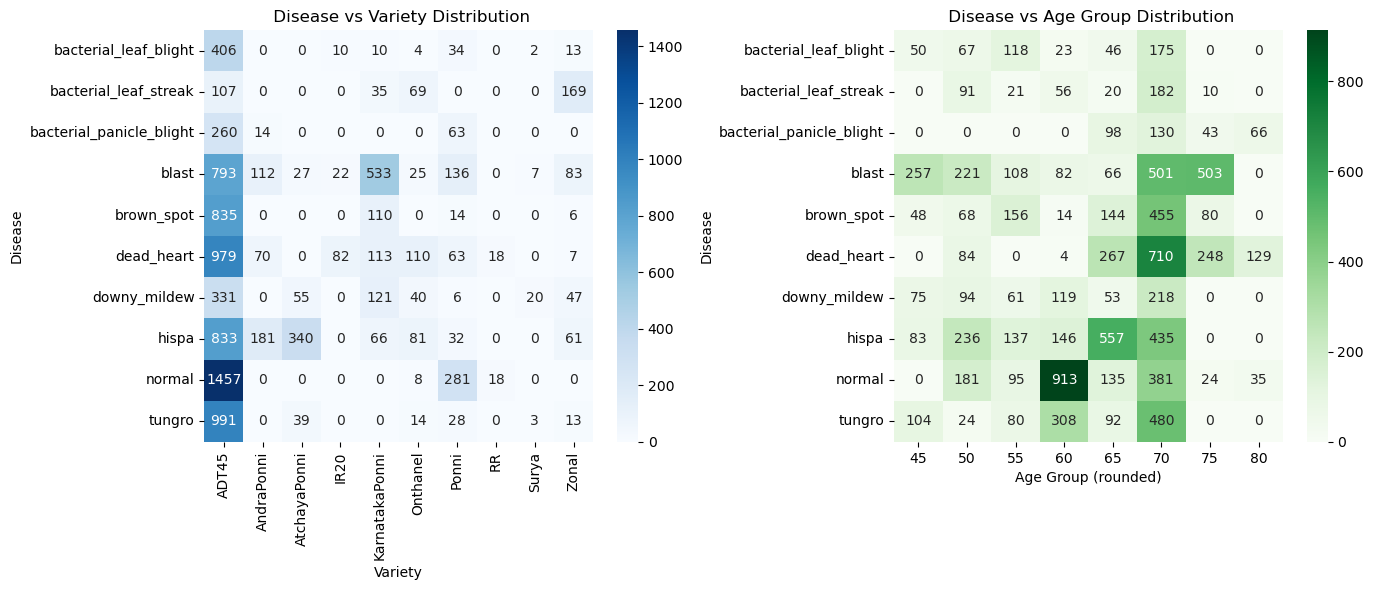

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load metadata ===
df = pd.read_csv("meta_train.csv")

# Optional cleanup (just in case)
df['image_id'] = df['image_id'].astype(str)
df = df.dropna(subset=['label', 'variety', 'age'])

# Round age to nearest 5 for grouping (optional)
df['age_group'] = (df['age'] // 5) * 5

# === Pivot table: count of samples per (label, variety) or (label, age_group) ===
pivot_variety = pd.pivot_table(df, index='label', columns='variety', aggfunc='size', fill_value=0)
pivot_age = pd.pivot_table(df, index='label', columns='age_group', aggfunc='size', fill_value=0)

# === Plot heatmaps ===
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(pivot_variety, annot=True, fmt='d', cmap='Blues')
plt.title(" Disease vs Variety Distribution")
plt.xlabel("Variety")
plt.ylabel("Disease")

plt.subplot(1, 2, 2)
sns.heatmap(pivot_age, annot=True, fmt='d', cmap='Greens')
plt.title(" Disease vs Age Group Distribution")
plt.xlabel("Age Group (rounded)")
plt.ylabel("Disease")

plt.tight_layout()
plt.show()

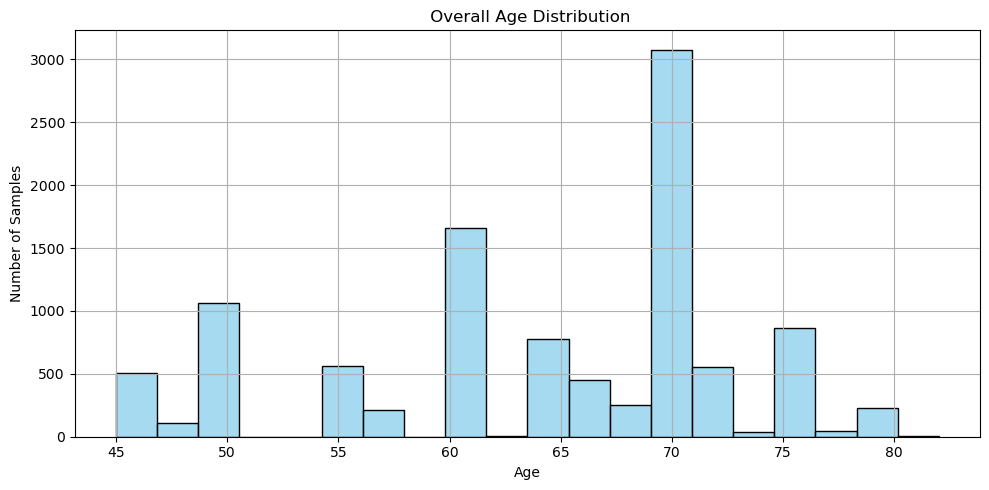

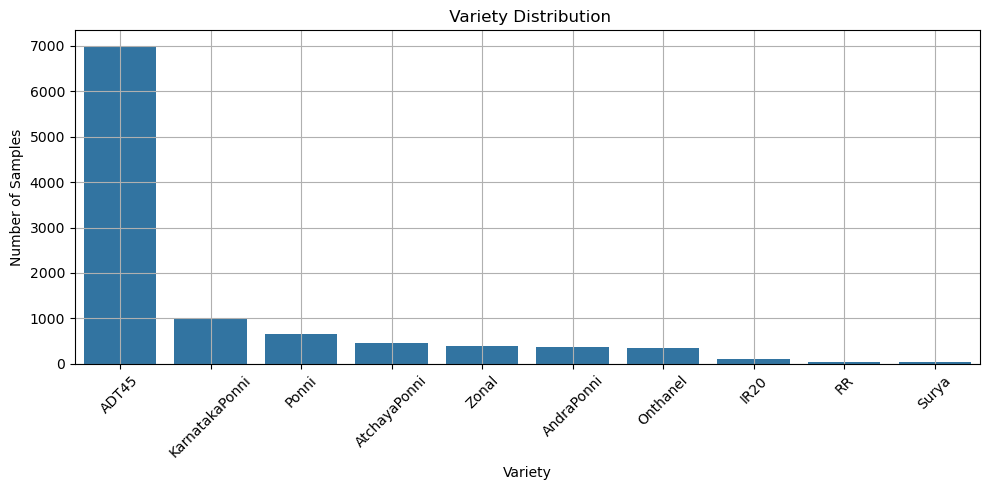

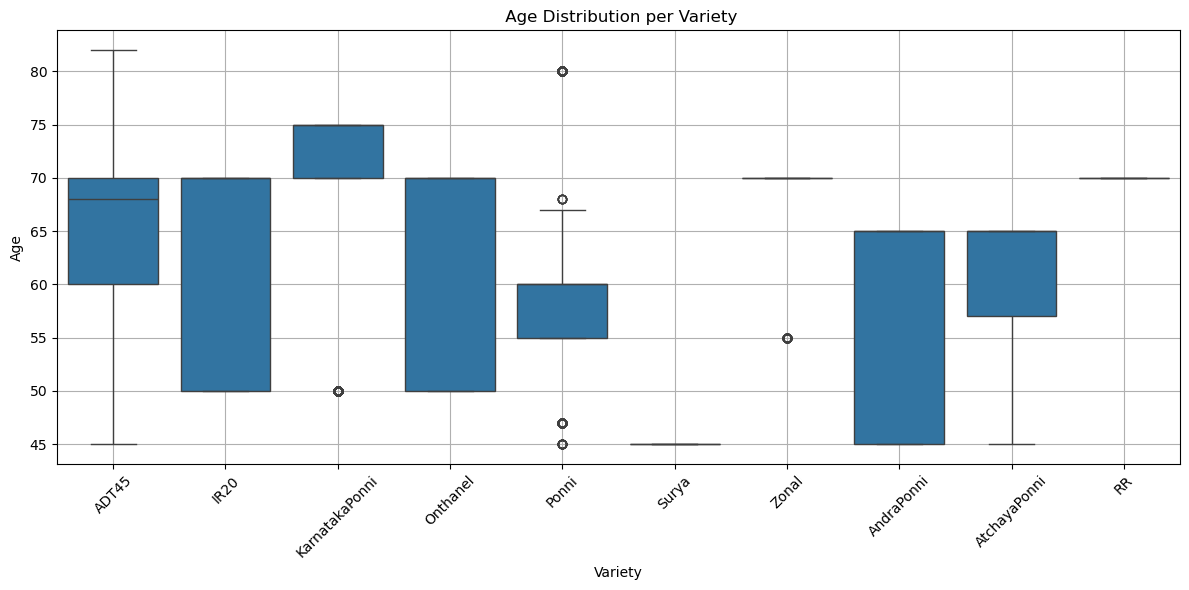

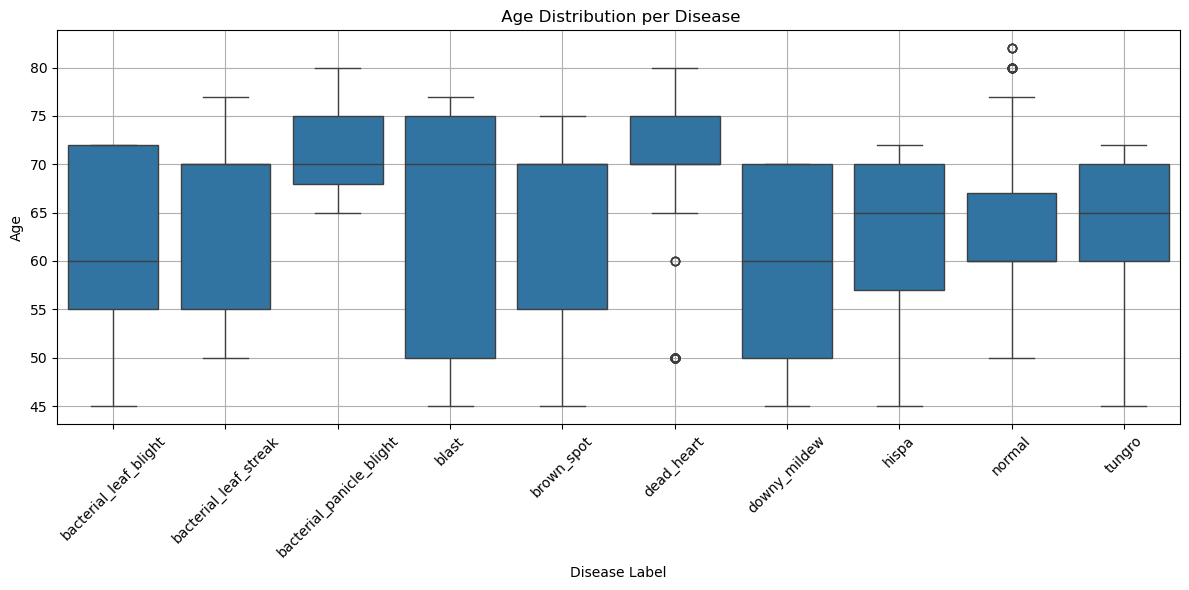

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
META_CSV = "meta_train.csv"  # <-- Ensure this file is in your working directory

# === Load metadata ===
df = pd.read_csv(META_CSV)
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["variety"] = df["variety"].astype(str)
df["label"] = df["label"].astype(str)

# === Block 1: Overall Age Distribution ===
plt.figure(figsize=(10, 5))
sns.histplot(df["age"], bins=20, kde=False, color="skyblue")
plt.title(" Overall Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Block 2: Variety Count Distribution ===
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="variety", order=df["variety"].value_counts().index)
plt.title(" Variety Distribution")
plt.xlabel("Variety")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Block 3: Boxplot of Age per Variety ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="variety", y="age")
plt.title(" Age Distribution per Variety")
plt.xlabel("Variety")
plt.ylabel("Age")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# === Block 4: Boxplot of Age per Disease ===
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="label", y="age")
plt.title(" Age Distribution per Disease")
plt.xlabel("Disease Label")
plt.ylabel("Age")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [38]:
import os
from collections import defaultdict

# === CONFIG ===
TRAIN_DIR = "dataset/train"
IMG_EXT = (".jpg", ".jpeg", ".png")
MINORITY_THRESHOLD = 500  # Adjust this threshold based on your dataset

# === Count images per class ===
class_counts = defaultdict(int)

for class_name in sorted(os.listdir(TRAIN_DIR)):
    class_path = os.path.join(TRAIN_DIR, class_name)
    if not os.path.isdir(class_path):
        continue
    count = sum(fname.lower().endswith(IMG_EXT) for fname in os.listdir(class_path))
    class_counts[class_name] = count

# === Identify minority classes ===
minority_classes = [cls for cls, count in class_counts.items() if count < MINORITY_THRESHOLD]

print("Class distribution:")
for cls, count in class_counts.items():
    print(f"{cls:30s}: {count} images")

print("\nIdentified minority classes (less than {} images):".format(MINORITY_THRESHOLD))
print(minority_classes)


Class distribution:
bacterial_leaf_blight         : 383 images
bacterial_leaf_streak         : 304 images
bacterial_panicle_blight      : 270 images
blast                         : 1390 images
brown_spot                    : 772 images
dead_heart                    : 1154 images
downy_mildew                  : 496 images
hispa                         : 1275 images
normal                        : 1411 images
tungro                        : 870 images

Identified minority classes (less than 500 images):
['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'downy_mildew']


In [46]:
import os
import Augmentor

# Define the path to your training dataset
dataset_path = "dataset/train"


# Define augmentation operations
for class_name in minority_classes:
    class_path = os.path.join(dataset_path, class_name)
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.sample(1000)  # Adjust the number based on your needs


Initialised with 383 image(s) found.
Output directory set to dataset/train/bacterial_leaf_blight/output.

Processing <PIL.Image.Image image mode=RGB size=480x640 at 0x3130B01F0>: 100%|█|


Initialised with 304 image(s) found.
Output directory set to dataset/train/bacterial_leaf_streak/output.

Processing <PIL.Image.Image image mode=RGB size=480x640 at 0x3140CCF10>: 100%|█|


Initialised with 270 image(s) found.
Output directory set to dataset/train/bacterial_panicle_blight/output.

Processing <PIL.Image.Image image mode=RGB size=480x640 at 0x313227B50>: 100%|█|


Initialised with 496 image(s) found.
Output directory set to dataset/train/downy_mildew/output.

Processing <PIL.Image.Image image mode=RGB size=480x640 at 0x31250EB50>: 100%|█|


In [56]:
from collections import defaultdict
import os

def count_images(folder):
    counts = defaultdict(int)
    for cls in sorted(os.listdir(folder)):
        cls_dir = os.path.join(folder, cls)
        if not os.path.isdir(cls_dir): continue

        # Include images in root and output (if exists)
        img_files = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        output_dir = os.path.join(cls_dir, "output")
        if os.path.exists(output_dir):
            img_files += [f for f in os.listdir(output_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

        counts[cls] = len(img_files)
    return counts

before_aug = class_counts  # from previous run before augmentation
after_aug = count_images("dataset/train")

print(f"{'Class':30s} | Before | After")
print("-" * 50)
for cls in sorted(after_aug):
    b = before_aug.get(cls, 0)
    a = after_aug[cls]
    print(f"{cls:30s} | {b:6d} | {a:5d}")


Class                          | Before | After
--------------------------------------------------
bacterial_leaf_blight          |    383 |  1383
bacterial_leaf_streak          |    304 |  1304
bacterial_panicle_blight       |    270 |  1270
blast                          |   1390 |  1390
brown_spot                     |    772 |   772
dead_heart                     |   1154 |  1154
downy_mildew                   |    496 |  1496
hispa                          |   1275 |  1275
normal                         |   1411 |  1411
tungro                         |    870 |   870


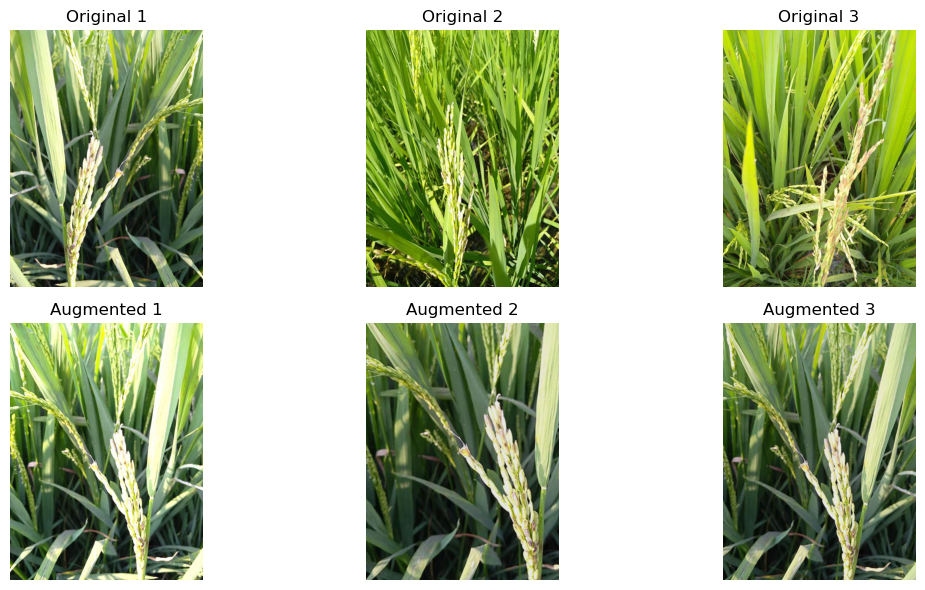

In [58]:
from PIL import Image
import matplotlib.pyplot as plt

# === CONFIG ===
class_to_view = "bacterial_panicle_blight"
original_dir = f"dataset/train/{class_to_view}"
augmented_dir = os.path.join(original_dir, "output")

original_imgs = sorted([f for f in os.listdir(original_dir) if f.lower().endswith(IMG_EXT)])[:3]
augmented_imgs = sorted([f for f in os.listdir(augmented_dir) if f.lower().endswith(IMG_EXT)])[:3]

# === Show side-by-side
plt.figure(figsize=(12, 6))
for i in range(3):
    orig_path = os.path.join(original_dir, original_imgs[i])
    aug_path = os.path.join(augmented_dir, augmented_imgs[i])
    
    # Original
    plt.subplot(2, 3, i+1)
    plt.imshow(Image.open(orig_path))
    plt.title(f"Original {i+1}")
    plt.axis('off')
    
    # Augmented
    plt.subplot(2, 3, i+4)
    plt.imshow(Image.open(aug_path))
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


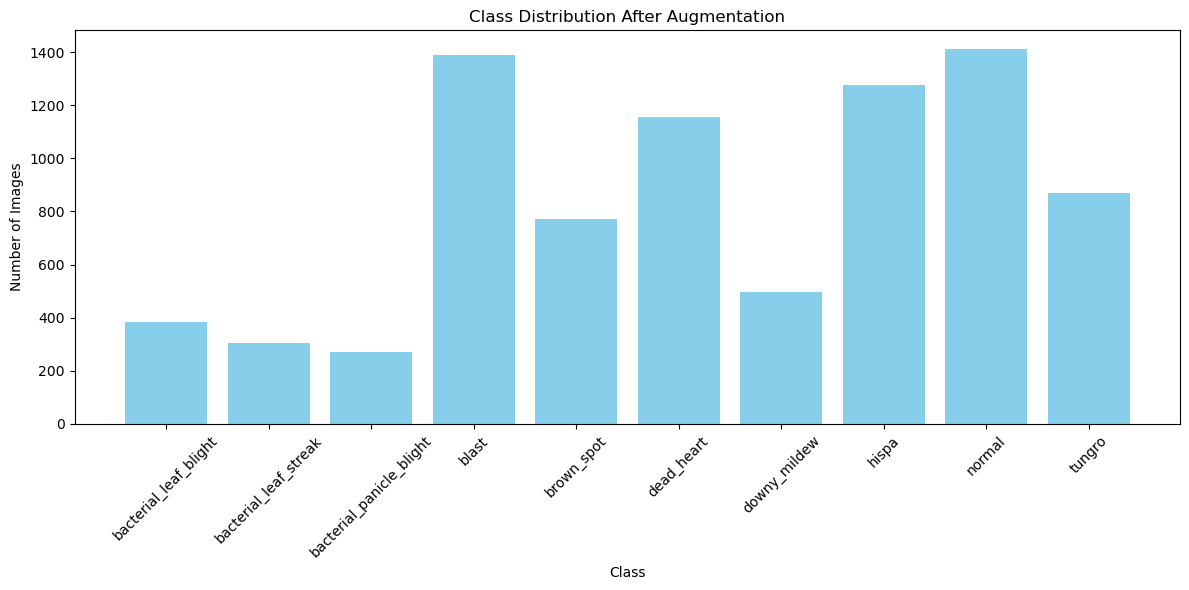

In [60]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the path to your training dataset
dataset_path = "dataset/train"
IMG_EXT = (".jpg", ".jpeg", ".png")

# Count images per class
class_counts = defaultdict(int)
for class_name in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue
    count = sum(fname.lower().endswith(IMG_EXT) for fname in os.listdir(class_path))
    class_counts[class_name] = count

# Plot the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution After Augmentation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [48]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Load your metadata
df = pd.read_csv("meta_train.csv")

# Encode categorical variables
le_variety = LabelEncoder()
df['variety_encoded'] = le_variety.fit_transform(df['variety'])

# Features and target
X = df[['age', 'variety_encoded']]
y = df['label']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled features and target into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=['age', 'variety_encoded'])
df_resampled['label'] = y_resampled


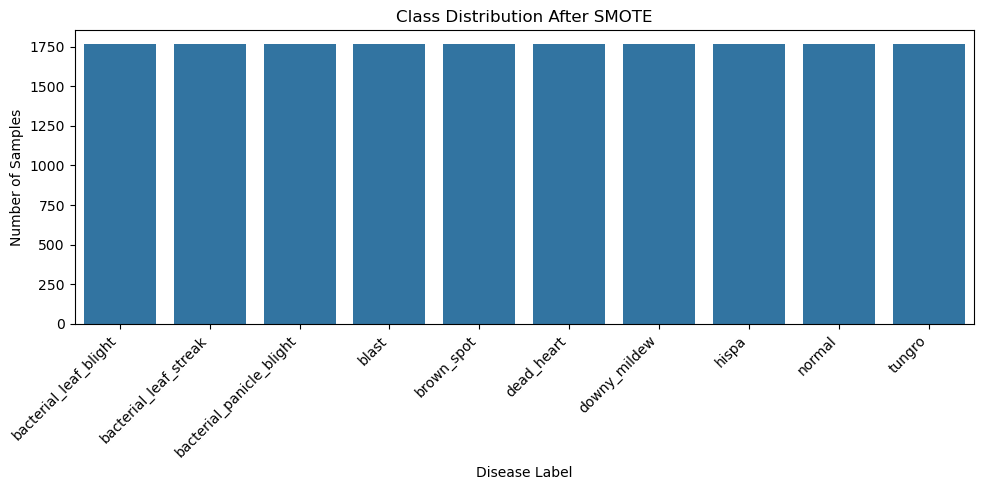

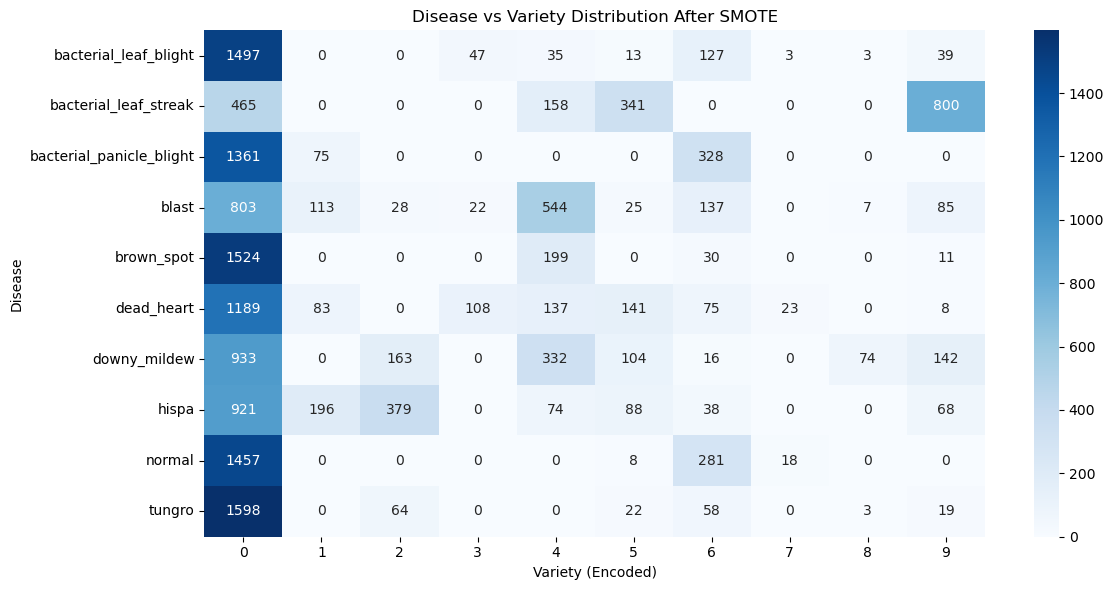

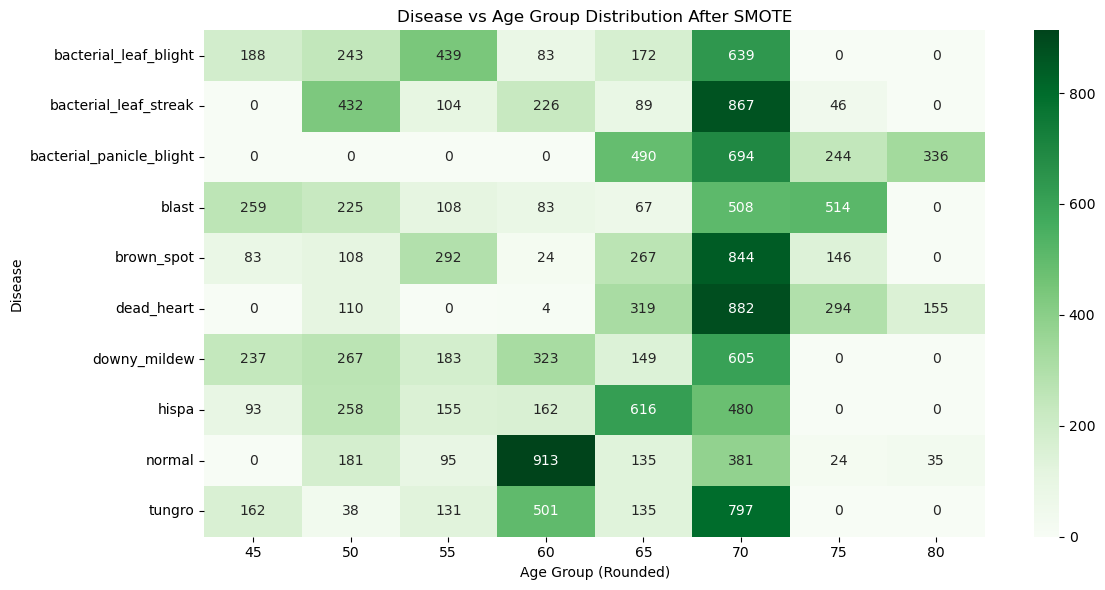

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Class Distribution After SMOTE ===
plt.figure(figsize=(10, 5))
sns.countplot(data=df_resampled, x='label', order=df_resampled['label'].value_counts().index)
plt.title("Class Distribution After SMOTE")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Samples")
plt.xlabel("Disease Label")
plt.tight_layout()
plt.show()

# === 2. Disease vs Variety Distribution After SMOTE ===
plt.figure(figsize=(12, 6))
pivot_variety = pd.crosstab(df_resampled['label'], df_resampled['variety_encoded'])
sns.heatmap(pivot_variety, cmap="Blues", annot=True, fmt='d')
plt.title("Disease vs Variety Distribution After SMOTE")
plt.xlabel("Variety (Encoded)")
plt.ylabel("Disease")
plt.tight_layout()
plt.show()

# === 3. Disease vs Age Group Distribution After SMOTE ===
df_resampled['age_group'] = (df_resampled['age'] // 5) * 5
plt.figure(figsize=(12, 6))
pivot_age = pd.crosstab(df_resampled['label'], df_resampled['age_group'])
sns.heatmap(pivot_age, cmap="Greens", annot=True, fmt='d')
plt.title("Disease vs Age Group Distribution After SMOTE")
plt.xlabel("Age Group (Rounded)")
plt.ylabel("Disease")
plt.tight_layout()
plt.show()


In [74]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_resampled is your target variable after SMOTE
classes = np.unique(y_resampled)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)

# Create a dictionary mapping class labels to weights
class_weight_dict = dict(zip(classes, class_weights))

# === Convert class_weight_dict to use integer keys ===
label_map = train_gen.class_indices
class_weight_dict_indexed = {label_map[k]: v for k, v in class_weight_dict.items()}



Found 12325 images belonging to 10 classes.
Found 2082 images belonging to 10 classes.
Epoch 1/100


2025-05-29 15:24:15.126907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


386/386 [==============================] - ETA: 0s - loss: 2.8853 - accuracy: 0.1226

2025-05-29 15:27:50.914455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


386/386 [==============================] - 231s 573ms/step - loss: 2.8853 - accuracy: 0.1226 - val_loss: 238.5176 - val_accuracy: 0.1662 - lr: 5.0000e-04
Epoch 2/100
386/386 [==============================] - 217s 561ms/step - loss: 2.5327 - accuracy: 0.1249 - val_loss: 48.7937 - val_accuracy: 0.1657 - lr: 5.0000e-04
Epoch 3/100
386/386 [==============================] - 216s 558ms/step - loss: 2.4564 - accuracy: 0.1389 - val_loss: 2.2973 - val_accuracy: 0.1724 - lr: 5.0000e-04
Epoch 4/100
386/386 [==============================] - 214s 553ms/step - loss: 2.4032 - accuracy: 0.1510 - val_loss: 3.6121 - val_accuracy: 0.1950 - lr: 5.0000e-04
Epoch 5/100
386/386 [==============================] - 214s 553ms/step - loss: 2.3646 - accuracy: 0.1609 - val_loss: 2.8372 - val_accuracy: 0.1984 - lr: 5.0000e-04
Epoch 6/100
386/386 [==============================] - 214s 554ms/step - loss: 2.3376 - accuracy: 0.1629 - val_loss: 2.4813 - val_accuracy: 0.1820 - lr: 5.0000e-04
Epoch 7/100
386/386 [====

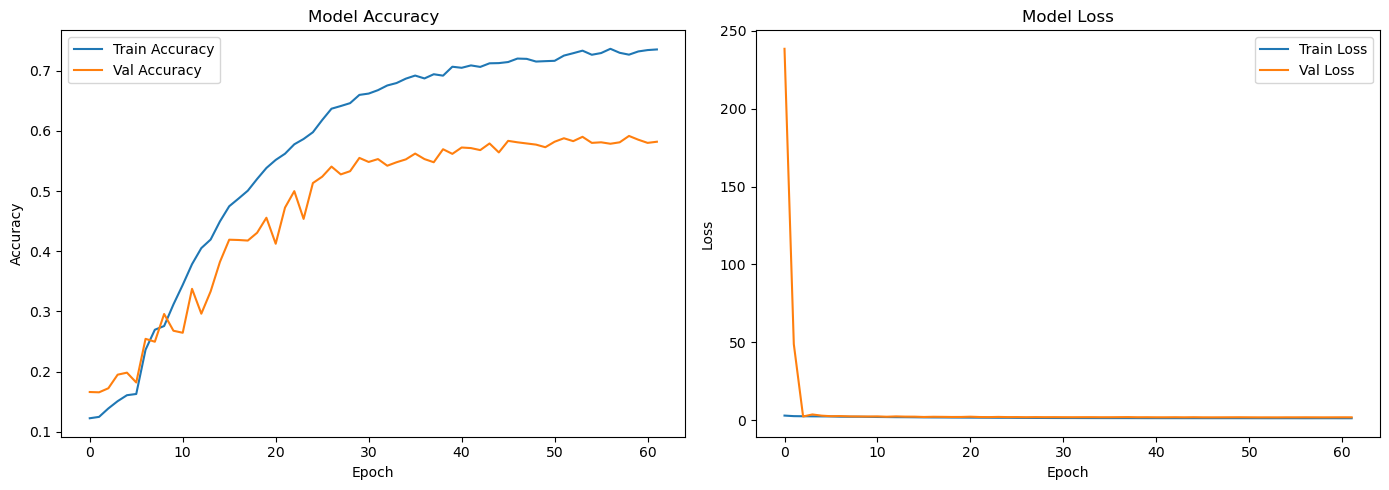

In [78]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# === CONFIG ===
IMG_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 100
TRAIN_DIR = "dataset/train"
VAL_DIR = "dataset/val"
NUM_CLASSES = len([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
CLASS_MODE = "categorical"

# === Data Augmentation ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

# === Model ===
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = InceptionV3(include_top=False, weights=None, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# === Compile ===
model.compile(
    optimizer=RMSprop(learning_rate=0.0005),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# === Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# === Train ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight= class_weight_dict_indexed  
)

# === Plot Training History ===
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



Found 12325 images belonging to 10 classes.
Found 2082 images belonging to 10 classes.
Found 12325 images belonging to 10 classes.
Epoch 1/100


2025-05-29 21:06:09.650109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


385/385 [==============================] - ETA: 0s - loss: 2.6154 - accuracy: 0.1284

2025-05-29 21:11:29.604584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


385/385 [==============================] - 335s 839ms/step - loss: 2.6154 - accuracy: 0.1284 - val_loss: 2.6972 - val_accuracy: 0.0433
Epoch 2/100
385/385 [==============================] - 307s 798ms/step - loss: 2.3976 - accuracy: 0.1435 - val_loss: 2.2733 - val_accuracy: 0.1072
Epoch 3/100
385/385 [==============================] - 304s 791ms/step - loss: 2.3270 - accuracy: 0.1599 - val_loss: 2.3198 - val_accuracy: 0.1774
Epoch 4/100
385/385 [==============================] - 302s 786ms/step - loss: 2.2629 - accuracy: 0.1887 - val_loss: 2.9603 - val_accuracy: 0.1317
Epoch 5/100
385/385 [==============================] - 302s 785ms/step - loss: 2.2092 - accuracy: 0.2270 - val_loss: 2.4350 - val_accuracy: 0.1654
Epoch 6/100
385/385 [==============================] - 303s 787ms/step - loss: 2.1414 - accuracy: 0.2533 - val_loss: 2.7481 - val_accuracy: 0.1971
Epoch 7/100
385/385 [==============================] - 302s 785ms/step - loss: 2.0831 - accuracy: 0.2769 - val_loss: 2.0922 - val_

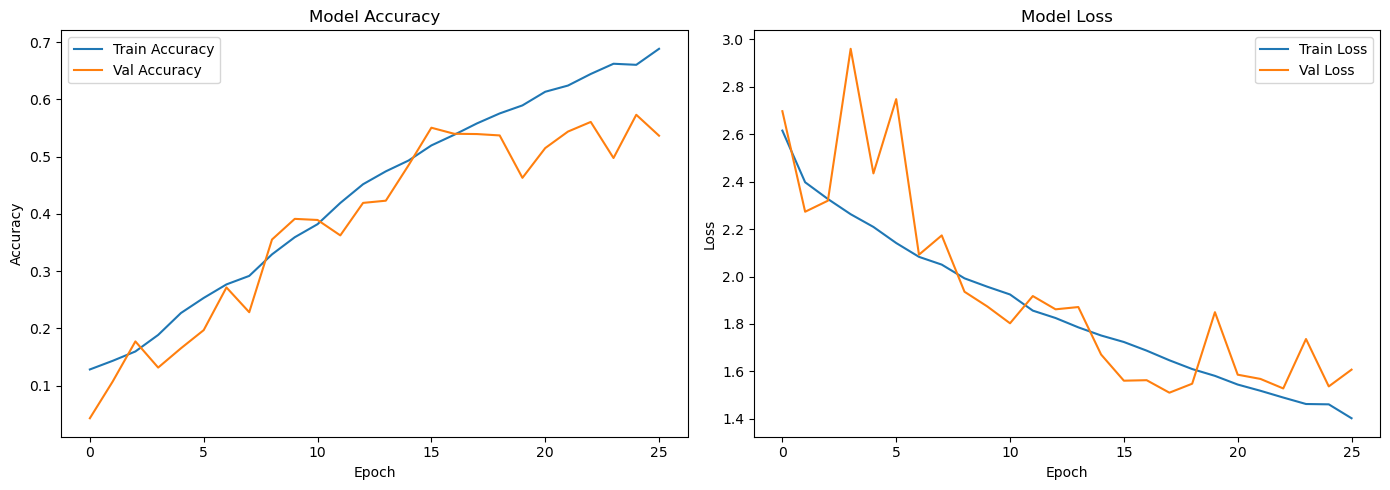

In [90]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# === CONFIG ===
IMG_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 100
TRAIN_DIR = "dataset/train"
VAL_DIR = "dataset/val"
CLASS_MODE = "categorical"

# === Count number of classes ===
NUM_CLASSES = len([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])

# === Label Preprocessing for Class Weights ===
base_datagen = ImageDataGenerator(rescale=1./255)
train_label_gen = base_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False
)
val_gen = base_datagen.flow_from_directory(
    VAL_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False
)

# === Compute Class Weights ===
labels = train_label_gen.classes
class_weights_arr = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights_arr))

# === Cosine Decay LR Schedule ===
initial_lr = 0.0005
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=EPOCHS * (train_label_gen.samples // BATCH_SIZE),
    alpha=1e-2
)

# === Custom Mixup Generator ===
def mixup_generator(generator, alpha=0.2):
    while True:
        x1, y1 = generator.next()
        x2, y2 = generator.next()
        min_len = min(len(x1), len(x2))
        x1, y1 = x1[:min_len], y1[:min_len]
        x2, y2 = x2[:min_len], y2[:min_len]
        l = np.random.beta(alpha, alpha, min_len)
        x_l = l.reshape(min_len, 1, 1, 1)
        y_l = l.reshape(min_len, 1)
        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)
        yield x, y

# === Data Augmentation ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

train_base_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode=CLASS_MODE, shuffle=True
)

train_gen = mixup_generator(train_base_gen)

# === Model ===
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = InceptionV3(include_top=False, weights=None, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# === Compile ===
model.compile(
    optimizer=RMSprop(learning_rate=lr_schedule),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# === Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]


# === Train ===
history = model.fit(
    train_gen,
    steps_per_epoch=train_label_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

# === Plot ===
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Found 12325 images belonging to 10 classes.
Found 2082 images belonging to 10 classes.
Found 12325 images belonging to 10 classes.
Epoch 1/100


2025-05-30 15:55:14.559250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


385/385 [==============================] - ETA: 0s - loss: 2.6494 - accuracy: 0.1211

2025-05-30 15:58:51.360900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


385/385 [==============================] - 236s 572ms/step - loss: 2.6494 - accuracy: 0.1211 - val_loss: 27.8018 - val_accuracy: 0.0346 - lr: 5.0000e-04
Epoch 2/100
385/385 [==============================] - 219s 567ms/step - loss: 2.3778 - accuracy: 0.1487 - val_loss: 2.4018 - val_accuracy: 0.1500 - lr: 5.0000e-04
Epoch 3/100
385/385 [==============================] - 1747s 5s/step - loss: 2.2804 - accuracy: 0.1939 - val_loss: 2.6722 - val_accuracy: 0.0644 - lr: 5.0000e-04
Epoch 4/100
385/385 [==============================] - 2054s 5s/step - loss: 2.2176 - accuracy: 0.2218 - val_loss: 2.2133 - val_accuracy: 0.2423 - lr: 5.0000e-04
Epoch 5/100
385/385 [==============================] - 1818s 5s/step - loss: 2.1398 - accuracy: 0.2621 - val_loss: 2.1353 - val_accuracy: 0.2553 - lr: 5.0000e-04
Epoch 6/100
385/385 [==============================] - 217s 564ms/step - loss: 2.0462 - accuracy: 0.3125 - val_loss: 2.4594 - val_accuracy: 0.2361 - lr: 5.0000e-04
Epoch 7/100
385/385 [============

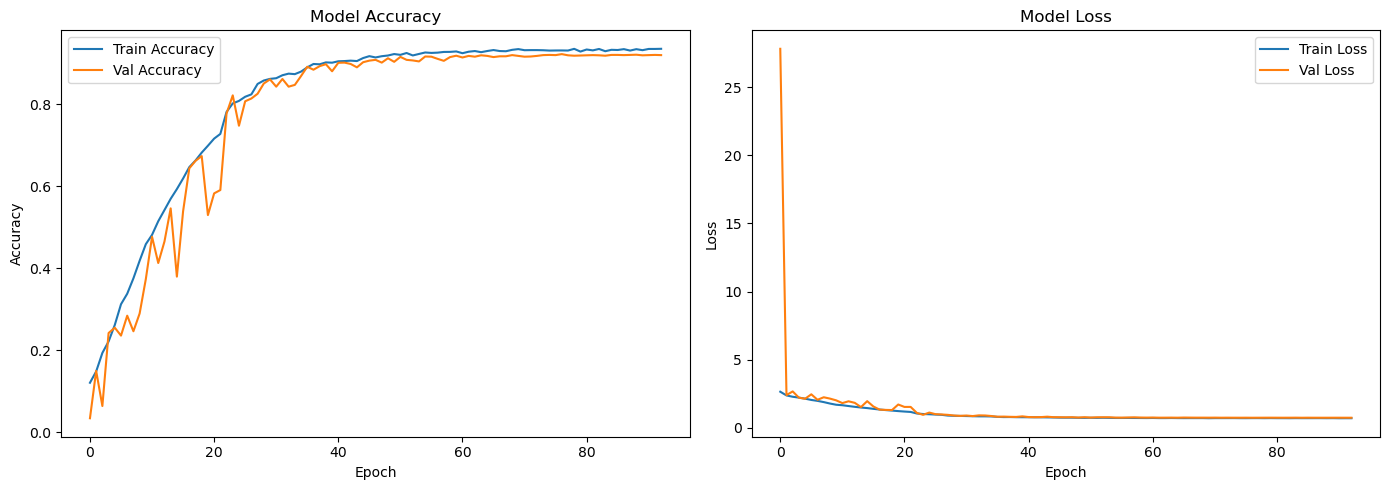

In [92]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# === CONFIG ===
IMG_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 100
TRAIN_DIR = "dataset/train"
VAL_DIR = "dataset/val"
CLASS_MODE = "categorical"

# === Count number of classes ===
NUM_CLASSES = len([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])

# === Label Preprocessing for Class Weights ===
base_datagen = ImageDataGenerator(rescale=1./255)
train_label_gen = base_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False
)
val_gen = base_datagen.flow_from_directory(
    VAL_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode=CLASS_MODE, shuffle=False
)

# === Compute Class Weights ===
labels = train_label_gen.classes
class_weights_arr = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights_arr))

# === Augmented Data Generator (without MixUp) ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode=CLASS_MODE, shuffle=True
)

# === Model ===
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = InceptionV3(include_top=False, weights=None, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# === Compile ===
model.compile(
    optimizer=RMSprop(learning_rate=0.0005),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# === Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# === Train ===
history = model.fit(
    train_gen,
    steps_per_epoch=train_label_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

# === Plot Training History ===
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
